In [4]:
from IPython.display import HTML
import pprint
import numpy as np
import matplotlib.pyplot as plt
import Python_modules.mmcomplexity as mmx

In [2]:
TITLE_FS = 22
AXES_FS = 22
LW = 3

In [7]:
HTML(
    '''
    <script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <a href="javascript:code_toggle()">TOGGLE CODE ON/OFF</a>
    '''
)

# Basic examples of `mmcomplexity` module

We generate a block of 10 trials with hazard rate 0.3:

In [8]:
num_trials = 500
hazard_rate = 0.3
stimulus = mmx.StimulusBlock(num_trials, hazard_rate)
print(stimulus)

object of type <class 'Python_modules.mmcomplexity.StimulusBlock'> 
 sources: ['left', 'right', 'right', 'left', 'left', 'left', 'right', 'right', 'left', 'left'] 
 sounds: ['left', 'right', 'left', 'left', 'left', 'left', 'left', 'right', 'right', 'left'] 



Next, we create an ideal observer and run the estimation task on it:

In [9]:
observer = mmx.KnownHazard(stimulus)

In [10]:
observer.observe()
print(f"observations: {observer.observations}")

observations: ['left', 'right', 'left', 'left', 'left', 'left', 'left', 'right', 'right', 'left']


In [ ]:
decisions = list(observer.process())
pprint.pprint(f"decisions: {decisions}")

Now, we generate a few blocks and display the stimulus info as a data frame (first few lines)

In [66]:
tot_trials, h_values, meta_k, meta_prior_h = 500, [.1, .9], .01, [.5, .5]
sim = mmx.Audio2AFCSimulation(tot_trials, h_values, meta_k, meta_prior_h)

In [67]:
pprint.pprint(sim.data.head())
sim.data.to_csv("sim_data.csv")

  source  source_switch  sound  sound_switch  hazard  hazard_switch
0   left          False   left         False     0.9          False
1  right           True  right          True     0.9          False
2  right          False  right         False     0.9          False
3   left           True   left          True     0.9          False
4  right           True  right          True     0.9          False


Now, we will display the cumulative frequencies of sound switches and source switches.

In [24]:
sound_switch_cumcount = np.cumsum(sim.data.loc[1:,"sound_switch"]) 
source_switch_cumcount = np.cumsum(sim.data.loc[1:,"source_switch"])
cum_trial = np.arange(1, source_switch_cumcount.size + 1)

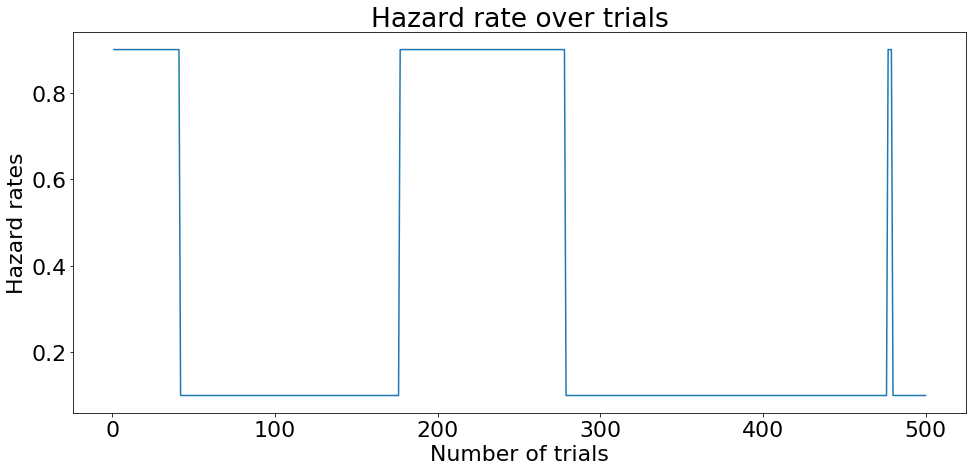

In [86]:
#Plotting hazard rate, sounds and sources vs. trial numbers, respectively
plt.title("Hazard rate over trials")
plt.xlabel("Number of trials")
plt.ylabel("Hazard rates")
m = np.arange(1, 501)
plt.plot(m, sim.data['hazard'])
plt.savefig('sim2_hazard_rate.png')


Clearly the effective h differs from the true h. We will run simulations to plot effective h as a function of true h, where effective h is defined as the cumulative frequency of sound switches after 5,000 trials.

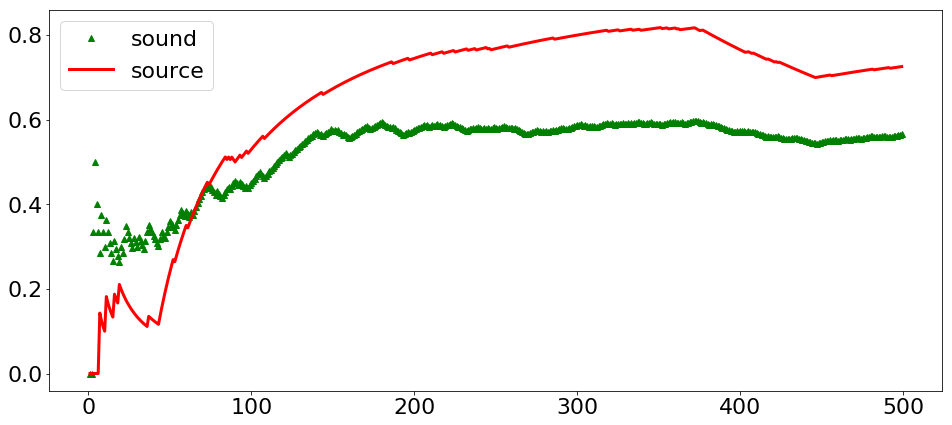

In [78]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 7) # (w, h) # figure size 
plt.rcParams.update({'font.size': AXES_FS}) # font size on axes
# plt.subplots_adjust(wspace=0.5) # horizontal space between panels

plt.plot(cum_trial, sound_switch_cumcount / cum_trial, 'g^')
plt.plot(cum_trial, source_switch_cumcount / cum_trial, linewidth=LW, color = 'red')
#plt.hlines(h_values, xmin=cum_trial[0], xmax=cum_trial[-1])
#plt.plot(cum_trial, )
plt.legend(['sound', 'source', 'true h'])
#plt.savefig('sim2_source.png')


Note that our current approximation of effective h is:
$$h^{effective}=[\nu(1-h)+(1-\nu)h](1-\nu)+[(1-h)(1-\nu)+h\nu]\nu$$
where $\nu$ is the probability that the sound occurs on the same side as the source (0.8 in our case), and $h$ is the hazard rate. We plot this equation as the red dots in the plot below.

In [12]:
def h_effective(h,nu):
    return (nu*(1-h)+(1-nu)*h)*(1-nu) + ((1-h)*(1-nu)+h*nu)*nu

In [14]:
true_h = np.linspace(0.05,0.95, 10)
effective_h = h_effective(true_h, 0.8)
print('true h values used:', true_h)

true h values used: [0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]


In [15]:
effective_h_emp = []
for h in true_h:
    # launch simulation
    tot_trials, h_values, meta_k, meta_prior_h = 5000, [h], 0, [1]
    sim = mmx.Audio2AFCSimulation(tot_trials, h_values, meta_k, meta_prior_h)
    
    # get effective h
    sound_switch_cumcount = np.array(np.cumsum(sim.data.loc[1:,"sound_switch"]))
    effective_h_emp.append(sound_switch_cumcount[-1] / (source_switch_cumcount.size + 1))

Text(0, 0.5, 'hazard estimate')

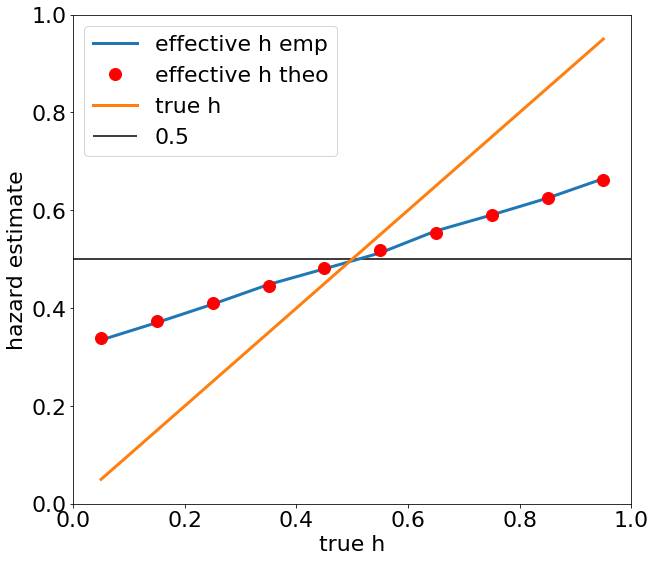

In [17]:
plt.rcParams["figure.figsize"] = (10, 9) # (w, h) # figure size 
plt.plot(true_h, effective_h_emp, linewidth=LW)
plt.plot(true_h, effective_h, 'or', markersize=12)
plt.plot(true_h, true_h, linewidth=LW)
plt.hlines(0.5, xmin=0, xmax=1)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(['effective h emp', 'effective h theo', 'true h', '0.5'])
plt.xlabel('true h')
plt.ylabel('hazard estimate')